# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, Febrary 23rd, 2018 at 11:00am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$
Based on your analysis of the loss function $L$, explain what is happening to your descent algorithms.

****

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline
import time
df = pd.read_csv('HW3_data.csv',header=None)

Text(0,0.5,'$\\lambda_1$')

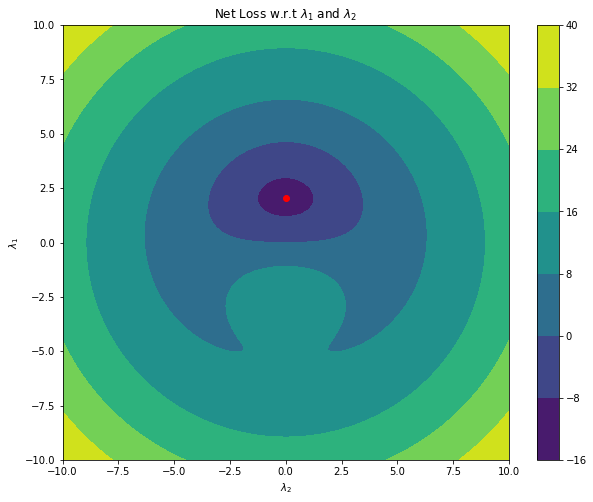

In [2]:
lambda1 = np.linspace(-10,10,100)
lambda2 = np.linspace(-10,10,100)

Lval = np.zeros((lambda1.shape[0],lambda2.shape[0]))

for i in range(len(lambda1)):
    for j in range(len(lambda2)):
        Lval[i,j] = np.sum(0.000045*lambda2[j]**2*df.iloc[1,:] - 0.000098*lambda1[i]**2*df.iloc[0,:] + 0.003926*lambda1[i]*df.iloc[0,:]*np.exp(-0.1*(lambda1[i]**2+lambda2[j]**2)))

plt.figure(figsize=(10,8))
plt.title(r'Net Loss w.r.t $\lambda_1$ and $\lambda_2$')
plt.contourf(lambda1,lambda2,Lval)
plt.colorbar()
plt.scatter(0,2.05384,c='r')
plt.xlabel(u'$\lambda_2$')
plt.ylabel(u'$\lambda_1$')

In [4]:

# total cost
def cost(x,y,l1,l2):
    return np.sum(0.000045*l2**2*y - 0.000098*l1**2*x + 0.003926*l1*x*np.exp(-0.1*(l1**2+l2**2)))

# total gradient
def grad(x,y,l1,l2):
    dldl1 = np.sum(-0.000196*l1*x + 0.003926*x*np.exp(-.1*(l1**2+l2**2)) -.2*(l1**2)*(0.003926)*x*np.exp(-.1*(l1**2+l2**2)))
    dldl2 = np.sum(0.00009*l2*y + 0.003926*l1*x*(-.2)*l2*np.exp(-.1*(l1**2+l2**2)))
    return( np.array([dldl1,dldl2]))

# some global variables
m = df.iloc[0,:].shape[0]
actual_lamb = np.array([2.05384,0])

# helps get indices of batch size
def get_ids(batch_size,vec_length):
    f = np.floor(vec_length/batch_size).astype(int)
    diff = vec_length - f*batch_size
    arr = []
    for i in range(f):
        arr.append([(i)*batch_size,(i+1)*batch_size])
    if diff != 0:
        arr.append([f*batch_size,f*batch_size+diff])
    return(arr)

# define minibatch
def minibatch(x, y, lamb_init,batch_size, step=1, maxsteps=10000, precision=10**(-3)):   
    tsgd = []
    hist = []
    costs = []
    bs = batch_size
    lamb = lamb_init
    counter = 0
    splitter = get_ids(bs,m)
    firstorder = np.random.permutation(m)
    epoch = 0 
    x = x[firstorder]
    y = y[firstorder]
    idx = 0
    splitlen = len(splitter)
    
    while np.linalg.norm(lamb-actual_lamb) > precision:
        a = time.clock()
        # divs for different scaling factors
        if div == 0:
            gradient = grad(x[splitter[idx][0]:splitter[idx][1]],y[splitter[idx][0]:splitter[idx][1]],lamb[0],lamb[1])/(bs)
        elif div == 1:
            gradient = grad(x[splitter[idx][0]:splitter[idx][1]],y[splitter[idx][0]:splitter[idx][1]],lamb[0],lamb[1])/np.sqrt(bs)
        else:
            gradient = grad(x[splitter[idx][0]:splitter[idx][1]],y[splitter[idx][0]:splitter[idx][1]],lamb[0],lamb[1])*(m)/(bs)
        lamb = lamb - step*gradient  # update
        hist.append(lamb)
        costs.append(cost(df.iloc[0,:],df.iloc[1,:],lamb[0],lamb[1]))
        counter+=1
        idx+=1
        if (splitlen) == 1:
            idx = 0
        if idx == (splitlen):#reached one past the end.
            #break
            epoch +=1
            neworder = np.random.permutation(m)
            x = x[neworder]
            y = y[neworder]
            idx = 0
        tsgd.append(time.clock()-a)
        
        if counter == maxsteps:
            break
    return(lamb,tsgd,hist,costs)


# plotting function
def make_3d_plot(xfinal, yfinal, zfinal, hist, costv):
    ms = np.linspace(xfinal - 2 , xfinal + 2, 20)
    bs = np.linspace(yfinal - 2 , yfinal + 2, 20)
    zs = np.zeros((len(ms),len(bs)))
    M, B = np.meshgrid(ms, bs)
    for i in range(len(ms)):
        for j in range(len(bs)):
            zs[i,j] =cost(df.iloc[0,:],df.iloc[1,:],ms[i],bs[j])
    Z = zs.reshape(M.shape)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
    ax.contour(M, B, Z, 20, alpha=0.5, offset=0, stride=30)
    ax.set_xlabel(r'$\lambda_1$')
    ax.set_ylabel(r'$\lambda_2$')
    ax.set_zlabel('Cost')
    ax.view_init(elev=30., azim=30)
    ax.plot([xfinal], [yfinal], [zfinal] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], costv , markerfacecolor='b', markeredgecolor='b', marker='.', markersize=5);
    ax.plot([t[0] for t in hist], [t[1] for t in hist], 0 , alpha=0.5, markerfacecolor='r', markeredgecolor='r', marker='.', markersize=5)
    
def gd_plot(theta, cost, hist):
    make_3d_plot(theta[0], theta[1], cost[-1], hist, cost)

In [7]:
dfrez = pd.DataFrame(columns =['step size','initial l1','initial l2','final l1','final l2','# iterations','total time','final cost'])

In [8]:
# div = 0 means divide by dataset size
# calculate gradient descent terms
lambdas = np.array([[-2.47865,0], [-3,0],[-5,0],[-10,0]])
steps = [1000,100,10,1]
for i in range(4):
    for j in range(len(steps)):
        div = 1
        lgd1,tgd1,hisgd1,costgd1 = minibatch(df.iloc[0,:],df.iloc[1,:],lambdas[i],m,step=steps[j])
        dfrez.loc[len(dfrez)] = [steps[j],lambdas[i][0],lambdas[i][1],lgd1[0],lgd1[1],len(tgd1),np.sum(tgd1),costgd1[-1]]


c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


In [9]:
print('Gradient Descent Algorithm')
dfrez

Gradient Descent Algorithm


,step size,initial l1,initial l2,final l1,final l2,# iterations,total time,final cost
0,1000.0,-2.47865,0.0,2.704140e+154,0.0,10000.0,20.365434,NaN
1,100.0,-2.47865,0.0,-5.363249e+00,0.0,10000.0,21.498636,8.161529
2,10.0,-2.47865,0.0,-5.363249e+00,0.0,10000.0,21.146995,8.161529
3,1.0,-2.47865,0.0,-5.363249e+00,0.0,10000.0,21.185660,8.161529
4,1000.0,-3.00000,0.0,2.751000e+154,0.0,10000.0,21.767731,NaN
5,100.0,-3.00000,0.0,-5.363249e+00,0.0,10000.0,21.444362,8.161529
6,10.0,-3.00000,0.0,-5.363249e+00,0.0,10000.0,21.179466,8.161529
7,1.0,-3.00000,0.0,-5.363249e+00,0.0,10000.0,21.135171,8.161529
8,1000.0,-5.00000,0.0,1.941973e+154,0.0,10000.0,21.589122,NaN
9,100.0,-5.00000,0.0,-5.363249e+00,0.0,10000.0,21.507645,8.161529


In [10]:
dfrezsgd = pd.DataFrame(columns =['step size','initial l1','initial l2','final l1','final l2','# iterations','total time','final cost'])

In [11]:
# div = 0 means divide by dataset size
# calculate stochastic gradient descent terms
lambdas = np.array([[-2.47865,0], [-3,0],[-5,0],[-10,0]])
steps = [1000,100,10,1]
for i in range(4):
    for j in range(len(steps)):
        div = 1
        lgd1,tgd1,hisgd1,costgd1 = minibatch(df.iloc[0,:],df.iloc[1,:],lambdas[i],1,step=steps[j])
        dfrezsgd.loc[len(dfrezsgd)] = [steps[j],lambdas[i][0],lambdas[i][1],lgd1[0],lgd1[1],len(tgd1),np.sum(tgd1),costgd1[-1]]


c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
c:\users\shaan desai\anaconda3\envs\am207\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


In [12]:
print('SGD Algorithm')
dfrezsgd

SGD Algorithm


,step size,initial l1,initial l2,final l1,final l2,# iterations,total time,final cost
0,1000.0,-2.47865,0.0,2.879125e+154,0.0,10000.0,18.563301,NaN
1,100.0,-2.47865,0.0,-1.716158e+02,0.0,10000.0,18.627954,5881.634864
2,10.0,-2.47865,0.0,-2.478646e+00,0.0,10000.0,18.319342,11.954580
3,1.0,-2.47865,0.0,-2.478646e+00,0.0,10000.0,18.172958,11.954580
4,1000.0,-3.00000,0.0,-9.421126e+154,0.0,10000.0,18.489289,NaN
5,100.0,-3.00000,0.0,2.054344e+00,0.0,8225.0,15.148051,-9.934103
6,10.0,-3.00000,0.0,-2.478646e+00,0.0,10000.0,18.195348,11.954580
7,1.0,-3.00000,0.0,-2.478646e+00,0.0,10000.0,18.057381,11.954580
8,1000.0,-5.00000,0.0,-2.793323e+154,0.0,10000.0,18.503593,NaN
9,100.0,-5.00000,0.0,1.282115e+01,0.0,10000.0,19.147302,32.827470


#### Results

Numerous observations can be made from the following results:
1. GD is not able to converge to the 'global' minima of the problem, regardless of aggressive or less aggressive step sizes. In fact, all runs hit the iteration limit.
2. GD's final l2 value is correct, but the l1 value either blows up or stops around the local minimum.
3. SGD is able to converge to the global minimum with the right step size occassionally. We see that for step of 100 and initial conditions of (-3,0) and for step size 100 with conditions (-10,0) we actually converge. This shows us that SGD can help us get to the global minimum.
4. SGD's final l2 value is always correct, but l1 certainly blows up in most instances or converges to -2.478 which is the maximum.

## Problem 2: Logistic Regression and MNIST (contd)




The MNIST dataset is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves. It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. 

Last time you used PyTorch to build a handwritten digit multi-class logistic regression classifier that you trained and tested with MNIST dataset.

We'll introduce validation sets and regularization in this problem.

Using the softmax formulation, write a PyTorch model that computes the cost function using an L2 regularization approach (see `optim.SGD` in PyTorch or write your own cost function) and minimizes the resulting cost function using mini-batch stochastic gradient descent.

Construct and train your classifier using a batch size of 256 examples, a learning rate η=0.1, and a regularization factor λ=0.01.

1. Using classification accuracy, evaluate how well your model is performing on the validation set at the end of each epoch. Plot this validation accuracy as the model trains. 
2. Duplicate this plot for some other values of the regularization parameter $\lambda$. When should you stop the training for different values of λ? Give an approximate answer supported by using the plots.
3. Select what you consider the best regularization parameter and predict the labels of the test set. Compare with the given labels. What classification accuracy do you obtain on the test set?

#### Parts 1 and 2

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [8]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])
train= dset.MNIST(root='processed/',train=True,transform=transform,download=True)
test = dset.MNIST(root='processed/',train=False,transform=transform,download=True)

## We need to further split our training dataset into training and validation sets.

# Define the indices
indices = list(range(len(train))) # start with all the indices in training set
split = 10000 # define the split size

# Define your batch_size
batch_size = 256

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]


# define our samplers -- we use a SubsetRandomSampler because it will return
# a random subset of the split defined by the given indices without replacement
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# Create the train_loader -- use your real batch_size which you
# I hope have defined somewhere above
train_loader = torch.utils.data.DataLoader(dataset=train, 
                batch_size=batch_size, sampler=train_sampler)

# You can use your above batch_size or just set it to 1 here.  Your validation
# operations shouldn't be computationally intensive or require batching.
validation_loader = torch.utils.data.DataLoader(dataset=train, 
                batch_size=1, sampler=validation_sampler)

# You can use your above batch_size or just set it to 1 here.  Your test set
# operations shouldn't be computationally intensive or require batching.  We 
# also turn off shuffling, although that shouldn't affect your test set operations
# either
test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=1,
                                          shuffle=False)

In [15]:
def imshow(img):
    img = img*0.3081+0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [9]:
from torch.nn import functional as fn
def modparams(decay):
    inp = 784
    outp = 10
    class Model(torch.nn.Module):

        def __init__(self):
            """
            In the constructor we instantiate two nn.Linear module
            """
            super(Model, self).__init__()
            # takes in the flattened image and outputs 10 linear functions
            self.linear = torch.nn.Linear(inp, outp)  # One in and one out
        
        def forward(self, x):
            """
            In the forward function we accept a Variable of input data and we must return
            a Variable of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Variables.
            """
            # simply predict(I could have had softmax as another layer but I chose to use nn.crossentropyloss which has that built-in)
            y_pred = self.linear(x)
            return y_pred

    # our model
    model = Model()


    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.
    criterion = nn.CrossEntropyLoss()
    # weight decay helps regularize
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1,weight_decay =decay)


#     stored_loss = []
    cv_score = []
    # Training loop
    for epoch in range(15):
        for i, (images,labels) in enumerate(train_loader):
            i
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(Variable(images.view(images.shape[0],-1)))

            # Compute and print loss
            loss = criterion(y_pred, Variable(labels))

#              stored_loss.append(loss.data[0])

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
         # Cross Validation Score
        a = nn.Softmax(dim=1)
        count_true = 0
        count_false = 0
        # predict in batches (since this is how our data is)
        for i, (images,labels) in enumerate(validation_loader):
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(Variable(images.view(images.shape[0],-1)))
            vals,idxs = torch.max(a(y_pred),dim=1)
            preds = idxs.data.numpy()
            lbs = labels.numpy()
#             print(preds,lbs)
            count_true += np.sum(preds==lbs)
            count_false += np.sum(preds!=lbs)   
        cv_score.append(count_true/(count_true + count_false))
    return(cv_score)

In [22]:
param_grid = [1,0.1,0.01,0.001,.0001]
cvscores = []
for i in range(len(param_grid)):
    cvscores.append(modparams(param_grid[i]))

Text(0.5,1,'Cross Validation Accuracy/epoch')

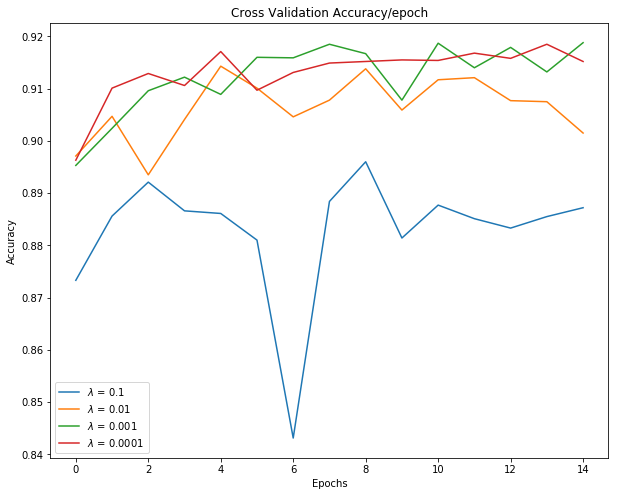

In [24]:
# plotting of cv scores
plt.figure(figsize=(10,8))
for i in range(len(param_grid)-1):
    plt.plot(range(15),cvscores[i+1],label = '$\lambda$ = ' + str(param_grid[i+1]))
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Cross Validation Accuracy/epoch')

##### Lambda cutoffs

We should stop training when we get a high validation accuracy since that helps us get a sense for how we will perform in an out of sample case.
For lambda 1 we see that the CV score fluctuates a lot so we cannot determine an epoch cutoff.
For lambda 0.1 we see it is maximized at 8 epochs so thats a good cutoff.
For the remaining lambdas there is quite a bit of fluctuation.
lambda 0.01 around 4 epochs.
lambda 0.001 around 6 epochs.
lambda 0.0001 around 13 epochs.

This obviously all depends on the validation set we get and so we can't jump to conclusions here. What we really need to do is cross validate, that way we can have uncertainty bars on these predictions.


#### Part 3

In [10]:
from torch.nn import functional as fn
def modparams(decay=0.0001):
    inp = 784
    outp = 10
    class Model(torch.nn.Module):

        def __init__(self):
            """
            In the constructor we instantiate two nn.Linear module
            """
            super(Model, self).__init__()
            # takes in the flattened image and outputs 10 linear functions
            self.linear = torch.nn.Linear(inp, outp)  # One in and one out
        
        def forward(self, x):
            """
            In the forward function we accept a Variable of input data and we must return
            a Variable of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Variables.
            """
            # simply predict(I could have had softmax as another layer but I chose to use nn.crossentropyloss which has that built-in)
            y_pred = self.linear(x)
            return y_pred

    # our model
    model = Model()


    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.
    criterion = nn.CrossEntropyLoss()
    # weight decay helps regularize
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1,weight_decay =decay)


#     stored_loss = []
    cv_score = []
    test_score = []
    # Training loop
    for epoch in range(10):
        for i, (images,labels) in enumerate(train_loader):
            i
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(Variable(images.view(images.shape[0],-1)))

            # Compute and print loss
            loss = criterion(y_pred, Variable(labels))

#              stored_loss.append(loss.data[0])

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Cross Validation Score
        a = nn.Softmax(dim=1)
        count_true = 0
        count_false = 0 
        # predict in batches (since this is how our data is)
        for i, (images,labels) in enumerate(validation_loader):
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(Variable(images.view(images.shape[0],-1)))
            vals,idxs = torch.max(a(y_pred),dim=1)
            preds = idxs.data.numpy()
            lbs = labels.numpy()
            count_true += np.sum(preds==lbs)
            count_false += np.sum(preds!=lbs)   
        cv_score.append(count_true/(count_true + count_false))

        # Test Score 
        a = nn.Softmax(dim=1)
        count_true = 0
        count_false = 0
        # predict in batches (since this is how our data is)
        for i, (images,labels) in enumerate(test_loader):
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(Variable(images.view(images.shape[0],-1)))
            vals,idxs = torch.max(a(y_pred),dim=1)
            preds = idxs.data.numpy()
            lbs = labels.numpy()
            count_true += np.sum(preds==lbs)
            count_false += np.sum(preds!=lbs)   
        test_score.append(count_true/(count_true + count_false))

    return(cv_score,test_score)

In [11]:
cv,test = modparams()

Text(0.5,1,'Validation Accuracy/epoch')

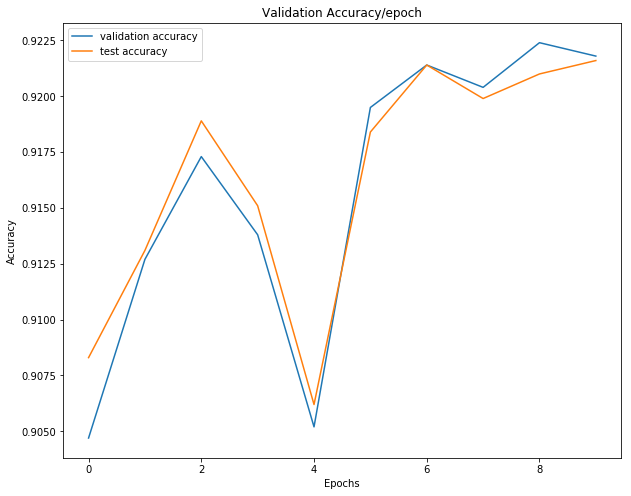

In [13]:
# plotting of cv scores
plt.figure(figsize=(10,8))
plt.plot(range(10),cv,label='validation accuracy')
plt.plot(range(10),test,label='test accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy/epoch')

##### Answers

In the end we chose lambda of 0.0001 since it had a stable validation score for epochs over 9. Since we said we wanted 10 epochs, our final Test set accuracy is roughly 0.921. In essence, we are not seeing much performance gain by validating and regularizing. Why? This is most probably driven by the fact that we didn't cross validate so we did not get a sense for the variance of validation on our parameters.

## Problem 3: Multi-Layer Perceptron

The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is usually chosen to be either the logistic function or the $\tanh$ function or the RELU function, and its purpose is to project the data into a space where it becomes linearly separable The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. 

![](http://deeplearning.net/tutorial/_images/mlp.png)

We'll construct a model with **1 hidden layer**. That is, you will have an input layer with a nonlinearity, then a hidden layer with the nonlinearity, and finally a cross-entropy (or equivalently log-softmax with a log-loss)


Using a similar architecture as in the first part and the same training, validation, and test sets, build a PyTorch model for the multilayer perceptron. Use the $\tanh$ function as the non-linear activation function. 

1. Use $\lambda = 0.001$ to compare with Problem 2. Experiment with the learning rate (try 0.1 and 0.01 for example), batch size (use 20, 50, 100 and 200) and the number of units in your hidden layer (use between 25 and 100 units). For what combination of these parameters do you obtain the highest validation accuracy after a resonable number of epochs that lead to convergence ( start at 10 epochs and play around a bit for convergence)? How does your test accuracy compare to the logistic regression classifier?
2. Try the same values of $\lambda$ you used in Question 2. Does the test set accuracy improve?


*Hint #1:* The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, you may find it advisable to initialize with the interval $[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.

*Hint #2*
Train/Validate/Test split can be done in numpy or in PyTorch. Lab will describe a way to do it keeping within the MNIST `DataLoader` workflow: the key is to pass a `SubsetRandomSampler` to `DataLoader`: see the docs.

In [35]:
# from torch.nn import functional as fn

# # standardize
# transform = transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))])
# train= dset.MNIST(root='processed/',train=True,transform=transform,download=True)
# test = dset.MNIST(root='processed/',train=False,transform=transform,download=True)


# # Define the indices
# indices = list(range(len(train))) # start with all the indices in training set
# split = 10000 # define the split size

# # Random, non-contiguous split
# validation_idx = np.random.choice(indices, size=split, replace=False)
# train_idx = list(set(indices) - set(validation_idx))

# # define our samplers -- we use a SubsetRandomSampler because it will return
# # a random subset of the split defined by the given indices without replacement
# train_sampler = SubsetRandomSampler(train_idx)
# validation_sampler = SubsetRandomSampler(validation_idx)


def modparams(decay,hidden_out,batch_size,epochs,learnr):
 
    # Define your batch_size
    batch_size = batch_size

    # Create the train_loader -- use your real batch_size which you
    # I hope have defined somewhere above
    train_loader = torch.utils.data.DataLoader(dataset=train, 
                    batch_size=batch_size, sampler=train_sampler)

    # You can use your above batch_size or just set it to 1 here.  Your validation
    # operations shouldn't be computationally intensive or require batching.
    validation_loader = torch.utils.data.DataLoader(dataset=train, 
                    batch_size=1, sampler=validation_sampler)

    # You can use your above batch_size or just set it to 1 here.  Your test set
    # operations shouldn't be computationally intensive or require batching.  We 
    # also turn off shuffling, although that shouldn't affect your test set operations
    # either
    test_loader = torch.utils.data.DataLoader(dataset=test, 
                                              batch_size=1,
                                              shuffle=False)
          

    inp = 784
    hidden_out = hidden_out
    output = 10
    class Model(torch.nn.Module):

        def __init__(self):
            """
            In the constructor we instantiate two nn.Linear module
            """
            super(Model, self).__init__()
            # takes in the flattened image and outputs 10 linear functions
            self.init_linear = torch.nn.Linear(inp, hidden_out)  # One in and one out
            torch.nn.init.xavier_uniform(self.init_linear.weight)
            self.nonlinear = fn.tanh
            self.final_linear = torch.nn.Linear(hidden_out,output)
            
        def forward(self, x):
            """
            In the forward function we accept a Variable of input data and we must return
            a Variable of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Variables.
            """
            # simply predict(I could have had softmax as another layer but I chose to use nn.crossentropyloss which has that built-in)
            l1 = self.init_linear(x)
            l2 = self.nonlinear(l1)            
            l3 = self.final_linear(l2)
            return l3

    # our model
    model = Model()

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learnr,weight_decay =decay)

    cv_score = []
    test_scores = []
    train_scores = []
    
#     # Training loop
    for epoch in range(epochs):
        for i, (images,labels) in enumerate(train_loader):
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(Variable(images.view(images.shape[0],-1)))
            # Compute and print loss
            loss = criterion(y_pred, Variable(labels))
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#     # Training Score/epoch
        a = nn.Softmax(dim=1)
#         count_true = 0
#         count_false = 0
       
#     # predict in batches (since this is how our data is) VALIDATION
#         for i, (images,labels) in enumerate(train_loader):
#             # Forward pass: Compute predicted y by passing x to the model
#             y_pred = model(Variable(images.view(images.shape[0],-1)))
#             vals,idxs = torch.max(a(y_pred),dim=1)
#             preds = idxs.data.numpy()
#             lbs = labels.numpy()
#             count_true += np.sum(preds==lbs)
#             count_false += np.sum(preds!=lbs)   
#         train_scores.append(count_true/(count_true + count_false))

      
    # Cross Validation Score/epoch
        count_true = 0
        count_false = 0

    # predict in batches (since this is how our data is) VALIDATION
        for i, (images,labels) in enumerate(validation_loader):
            # Forward pass: Compute predicted y by passing x to the model
            y_pred = model(Variable(images.view(images.shape[0],-1)))
            vals,idxs = torch.max(a(y_pred),dim=1)
            preds = idxs.data.numpy()
            lbs = labels.numpy()
            count_true += np.sum(preds==lbs)
            count_false += np.sum(preds!=lbs)   
        cv_score.append(count_true/(count_true + count_false))

#     # Test Score/epoch
#         count_true = 0
#         count_false = 0
    
#     # predict in batches (since this is how our data is) VALIDATION
#         for i, (images,labels) in enumerate(test_loader):
#             # Forward pass: Compute predicted y by passing x to the model
#             y_pred = model(Variable(images.view(images.shape[0],-1)))
#             vals,idxs = torch.max(a(y_pred),dim=1)
#             preds = idxs.data.numpy()
#             lbs = labels.numpy()
#             count_true += np.sum(preds==lbs)
#             count_false += np.sum(preds!=lbs)   
#         test_scores.append(count_true/(count_true + count_false))
#     return(test_scores)
#     return(train_scores,cv_score,test_scores)
    return(cv_score)

#### Part 1

So there are a range of parameters we need to go through. I choose to do these in a series of steps:
1. Find the best number of hidden layers
2. Find the best batch size
3. Find the best learning rate
4. Epochs for convergence

After optimizing this we then loop through a range of regularization coefficients.

In [16]:
hiddenls = [25,50,75,100]
vscore = []
for i in range(4):
    vscore.append(modparams(0.001,hiddenls[i],20,10,.1))

Text(0.5,1,'Validation Accuracy/epoch')

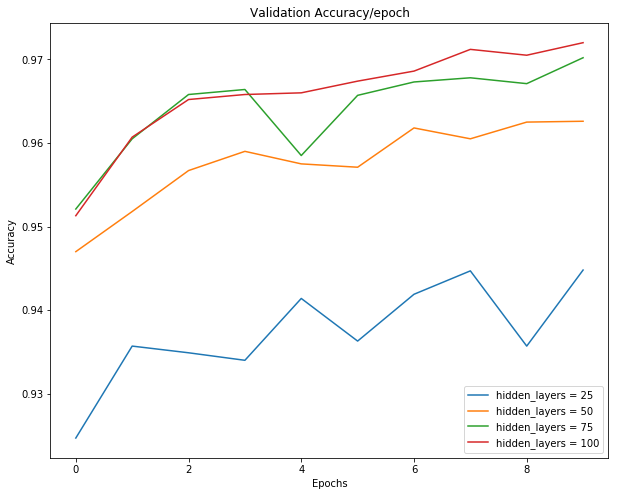

In [19]:
# plotting of cv scores
plt.figure(figsize=(10,8))
for i in range(len(hiddenls)):
    plt.plot(range(10),vscore[i],label = 'hidden_layers = ' + str(hiddenls[i]))
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy/epoch')

We can see that with 100 hidden layers we do a relaly good job. From now on we will use 100 hidden layers. Next, we optimize for the best batch size.

In [20]:
bsizes = [20,50,100,200]
bscore = []
for i in range(4):
    bscore.append(modparams(0.001,100,bsizes[i],10,.1))

Text(0.5,1,'Validation Accuracy/epoch')

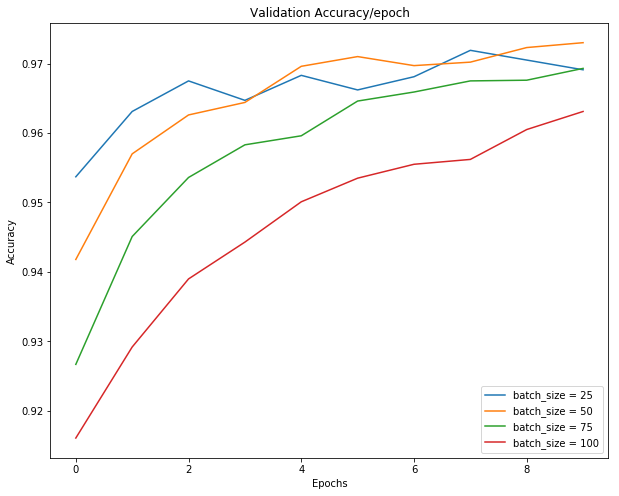

In [21]:
# plotting of batch scores
plt.figure(figsize=(10,8))
for i in range(len(bsizes)):
    plt.plot(range(10),bscore[i],label = 'batch_size = ' + str(hiddenls[i]))
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy/epoch')

From the graphs above it seems unclear whether batch size of 25 or 50 is good. I will go with a batch size of 50. Next, with the current parameters we need to see the score with two different learning rates.

In [22]:
lrs = [0.1,0.01]
lrscore = []
for i in range(2):
    lrscore.append(modparams(0.001,100,50,10,lrs[i]))

Text(0.5,1,'Validation Accuracy/epoch')

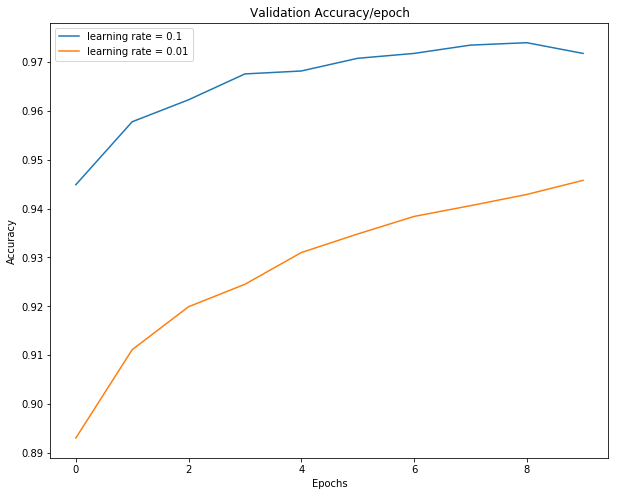

In [25]:
# plotting of batch scores
plt.figure(figsize=(10,8))
for i in range(len(lrs)):
    plt.plot(range(10),lrscore[i],label = 'learning rate = ' + str(lrs[i]))
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy/epoch')

Now we have effectively canvased all the major parameters of interest:
1. hidden layers = 100
2. batch size = 50
3. learning rate = 0.1

With these parameters, we run the experiment for 15 epochs to gain a sense for convergence then, report the test score.

In [26]:
scores = modparams(0.001,100,50,15,0.1)

Text(0.5,1,'Validation Accuracy/epoch')

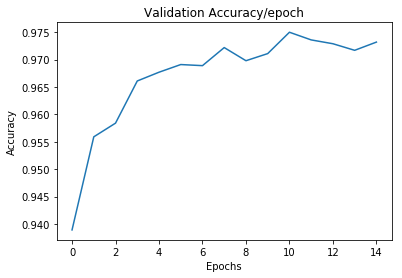

In [28]:
plt.figure()
plt.plot(range(15),scores)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy/epoch')

We can see from the graph that at about 6 epochs we start to plateau. There is some variation as the epochs grow but not significantly. Thus, we will stick with 10 epochs. Using these parameters, we then check the test accuracy.

In [30]:
test_scores = modparams(0.001,100,50,10,0.1)

In [33]:
print('The Test Performance Accuracy with the given paramaters = %s' %(test_scores[-1]))

The Test Performance Accuracy with the given paramaters = 0.9714


We can see that the test score is much higher through the addition of a hidden layer which is optimized. 

#### Part 2

In [37]:
lambdas = [0.1,0.01,0.001,0.0001]
lambda_score = []
for i in range(len(lambdas)):
    lambda_score.append(modparams(lambdas[i],100,50,10,0.1))

Text(0.5,1,'Validation Accuracy/epoch')

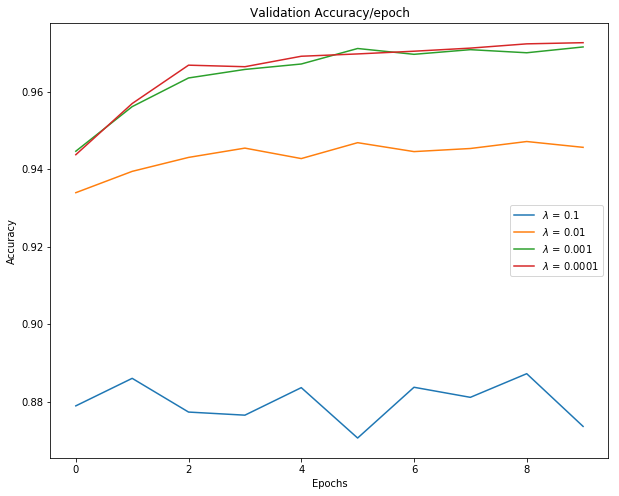

In [39]:
# plotting of batch scores
plt.figure(figsize=(10,8))
for i in range(len(lambdas)):
    plt.plot(range(10),lambda_score[i],label = '$\lambda$ = ' + str(lambdas[i]))
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy/epoch')

We can see that with the smaller lambdas we perform better. However, I cannot see significant performance gain between 0.001 and 0.0001. With this we can say that our original lambda of 0.001 is perhaps one of the best and therefore, our test score is the one listed in the previous section.